In [90]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne

# Auto-encoders 101
In this notebook you will implement a simple auto-encoder (AE). We assume that you are already familiar with the basics of neural networks. We'll start by defining an AE similar to the one used for the finetuning step by [Geoffrey Hinton and Ruslan Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf). We'll experiment with the AE setup and try to run it on the MNIST dataset. There has been a wide variety of research into the field of auto-encoders and the technique that you're about to learn is very simple compared to recent advances (e.g. [the Ladder network](https://arxiv.org/abs/1507.02672) and [VAEs](https://arxiv.org/abs/1312.6114)). However, the basic idea stays the same.

AEs are used within unsupervised learning, in which you do not have a target $y$. Instead it *encodes* an input $x$ into a latent state $z$ and decodes $z$ into a reconstruction $\hat{x}$. This way the parameters of the network can be optimized w.r.t. the difference between $x$ and $\hat{x}$. Depending on the input distribution, the difference can be measured in various ways, e.g. mean squared error (MSE). In many applications the auto-encoder will find an internal state of each data point corresponding to a feature. So if we are to model the MNIST dataset, one could expect that the internal state would correspond to a digit-class and/or the shape.

*The exercises are found at the bottom of the notebook*

## MNIST
First let us load the MNIST dataset and plot a few examples. We only load a limited amount of classes to speed up training.

In [91]:
from sklearn.utils import shuffle

# To speed up training we'll only work on a subset of the data containing only the numbers 0, 1.
data = np.load('../week1/mnist.npz')
num_classes = 2 ### Changed from 2 -> 3, and back
idxs_train = []
idxs_valid = []
idxs_test = []
for i in range(num_classes):
    idxs_train += np.where(data['y_train'] == i)[0].tolist()
    idxs_valid += np.where(data['y_valid'] == i)[0].tolist()
    idxs_test += np.where(data['y_test'] == i)[0].tolist()

x_train = data['X_train'][idxs_train].astype('float32')
targets_train = data['y_train'][idxs_train].astype('int32') # Since this is unsupervised, the targets are only used for validation.
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)


x_valid = data['X_valid'][idxs_valid].astype('float32')
targets_valid = data['y_valid'][idxs_valid].astype('int32')

x_test = data['X_test'][idxs_test].astype('float32')
targets_test = data['y_test'][idxs_test].astype('int32')

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)

training set dim(10610, 784).
validation set dim(2055, 784).
test set dim(2115, 784).


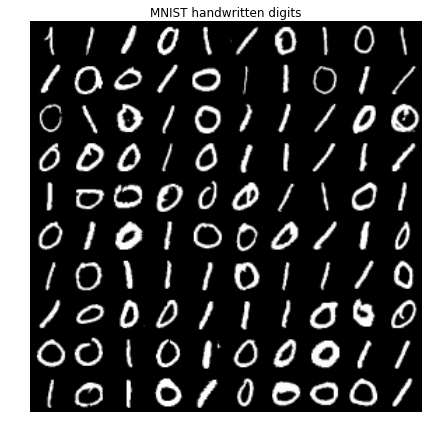

In [92]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')

### Building the model
When defining the model the latent layer $z$ must act as a bottleneck of information. We initialize the AE with 1 hidden layer in the encoder and decoder using relu units as non-linearities. The latent layer has a dimensionality of 2 in order to make it easy to visualise. Since $x$ are pixel intensities that are normalized between 0 and 1, we use the sigmoid non-linearity to model the reconstruction.

In [93]:
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import rectify, sigmoid

#define the model
num_features = x_train.shape[1]

l_in = InputLayer(shape=(None,num_features))
l_enc = DenseLayer(incoming=l_in, num_units=128, nonlinearity=rectify) ### Using sigmoid as non-linearity
l_enc2 = DenseLayer(incoming=l_enc, num_units=128, nonlinearity=rectify) ### Added encoder layer
l_enc3 = DenseLayer(incoming=l_enc2, num_units=128, nonlinearity=rectify) ### Added encoder layer
l_enc4 = DenseLayer(incoming=l_enc3, num_units=128, nonlinearity=rectify) ### Added encoder layer

### Changed nonlinearity of latent layer from None -> sigmoid, and back
### Changed num_units from 2 -> 3, and back
### Changed num_units from 2 -> 42, and back
l_z = DenseLayer(incoming=l_enc4, num_units=42, nonlinearity=None) # None indicates a linear output.
l_dec = DenseLayer(l_z, num_units=128, nonlinearity=rectify) ### Using sigmoid as non-linearity
l_dec2 = DenseLayer(l_dec, num_units=128, nonlinearity=rectify) ### Added decoder layer
l_dec3 = DenseLayer(l_dec2, num_units=128, nonlinearity=rectify) ### Added decoder layer
l_dec4 = DenseLayer(l_dec3, num_units=128, nonlinearity=rectify) ### Added decoder layer
l_out = DenseLayer(l_dec4, num_units=num_features, nonlinearity=sigmoid) # iid pixel intensities between 0 and 1.

Following we define the Theano functions for training and evaluation.

In [94]:
from lasagne.objectives import squared_error, binary_crossentropy

sym_x = T.matrix('sym_x') # a symbolic variable taking on the value of an input batch.

# Get network output
train_out, train_z = lasagne.layers.get_output([l_out, l_z], sym_x, deterministic=False)
eval_out, eval_z = lasagne.layers.get_output([l_out, l_z], sym_x, deterministic=True)

# Get list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

# cost = squared_error(train_out, sym_x).mean()
# eval_cost = squared_error(eval_out, sym_x).mean()

###
cost = binary_crossentropy(train_out, sym_x).mean()
eval_cost = binary_crossentropy(eval_out, sym_x).mean()

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)

# Set the update function for parameters 
# you might want to experiment with more advanced update schemes like adam, rmsprob, adadelta etc.
### Switched from sgd to adam, and back
updates = lasagne.updates.sgd(all_grads, all_params, learning_rate=0.25)


f_eval = theano.function([sym_x],
                     [eval_cost, eval_out, eval_z], on_unused_input='warn')

f_train = theano.function([sym_x],
                          [cost, train_out, train_z],
                          updates=updates, on_unused_input='warn')

In the training loop we sample each batch and evaluate the error, latent space and reconstructions every epoch.

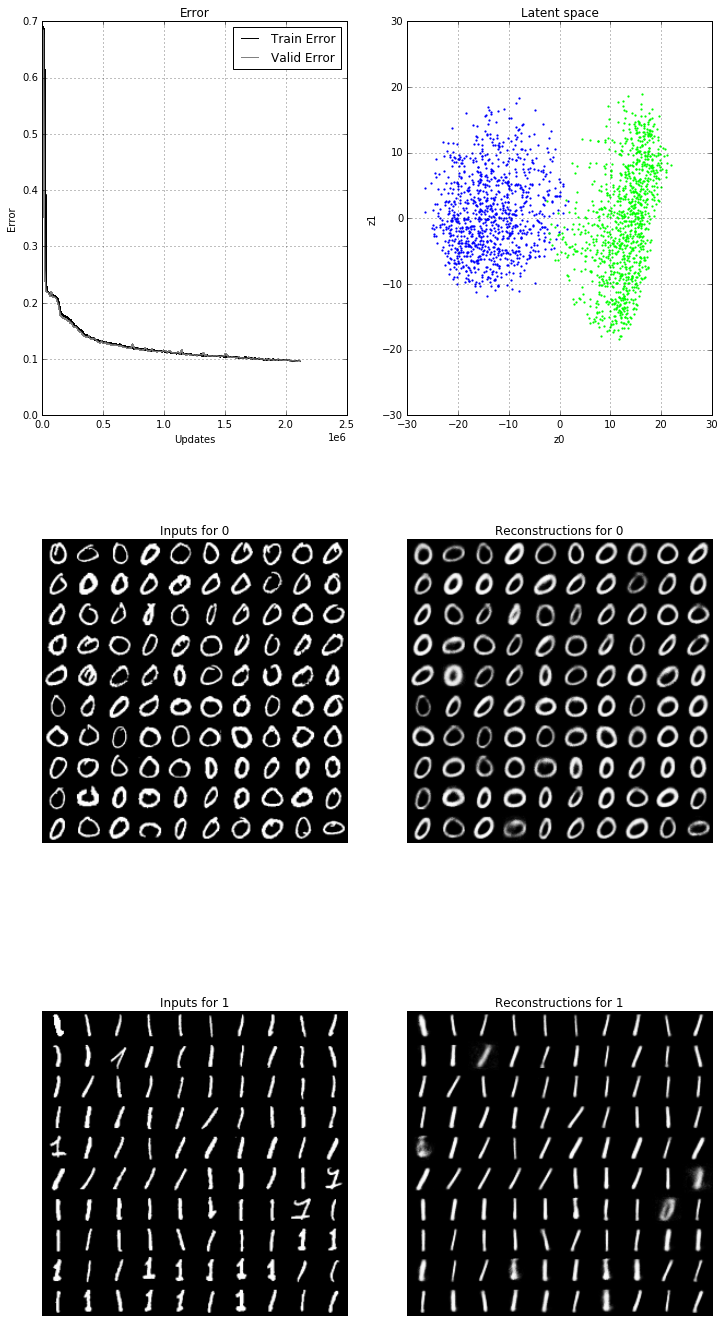

In [95]:
from sklearn.decomposition import PCA

batch_size = 100
num_epochs = 200 ### Changed from 100 -> 200, and back
learning_rate = 0.1
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size
updates = []

train_loss = []
valid_loss = []
cur_loss = 0
plt.figure(figsize=(12, 24))

try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = []
        for i in range(num_batches_train):
            idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)    
            x_batch = x_train[idxs]
            batch_loss, train_out, train_z = f_train(x_batch) #this will do the complete backprob pass
            cur_loss += [batch_loss]
        train_loss += [np.mean(cur_loss)]
        updates += [batch_size*num_batches_train*(epoch+1)]

        eval_loss, eval_out, eval_z = f_eval(x_valid)
        valid_loss += [eval_loss]

        if epoch == 0:
            continue

        # Plotting
        plt.subplot(num_classes+1,2,1)
        plt.title('Error')
        plt.legend(['Train Error', 'Valid Error'])
        plt.xlabel('Updates'), plt.ylabel('Error')
        plt.plot(updates, train_loss, color="black")
        plt.plot(updates, valid_loss, color="grey")
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.grid('on')

        plt.subplot(num_classes+1,2,2)
        plt.cla()
        plt.title('Latent space')
        plt.xlabel('z0'), plt.ylabel('z1')
        color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
        ### Using PCA to represent the many number of latent units
        pca = PCA(n_components=2)
        eval_z_reduced = pca.fit_transform(eval_z)
        for i in range(num_classes):
            clr = next(color)
            plt.scatter(eval_z_reduced[targets_valid==i, 0], eval_z_reduced[targets_valid==i, 1], c=clr, s=5., lw=0, marker='o', )
        plt.grid('on')
        
        c=0
        for k in range(3, 3 + num_classes*2, 2):
            plt.subplot(num_classes+1,2,k)
            plt.cla()
            plt.title('Inputs for %i' % c)
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_valid[targets_valid==c][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            plt.subplot(num_classes+1,2,k+1)
            plt.cla()
            plt.title('Reconstructions for %i' % c)
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = eval_out[targets_valid==c][idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            c+=1
      
        
        plt.savefig("out51.png")
        display(Image(filename="out51.png"))
        clear_output(wait=True)
        
except KeyboardInterrupt:
    pass
    

### Exercise 1 - Analyzing the AE
1. The above implementation of an AE is very simple.
    - *Experiment with the number of layers and non-linearities in order to improve the reconstructions.*
    - **Answer:** Two encoder and decoder layers seem to make the network improve much faster in the beginning. 
    - **Answer:** Using adam as update function results in the network not learning anything.. I cannot explain why. 
    - **Answer:** Using sigmoid as non-linearity in the enc and dec layers gives a smoother learning curve, but gives worse results.. The final train and valid errors are above 0.06. Regarding the reconstructions, each and every one (for 0 and 1) shows a combination of a 0 and a 1, but this does not seem consistent with the otherwise low error rate. 
    - **Answer:** Using four enc and dec layers and training on double the epocs gives a better result than the original. Could perhaps be improved further using more layers, but takes too long to train.
    - *What happens with the network when we change the non-linearities in the latent layer (e.g. sigmoid)?*
    - **Answer:** Using sigmoid the two classes cannot be separated in the latent space.
    - *Try to increase the number of digit classes in the training set and analyze the results.*
    - **Answer:** Using just 2 num_units in the latent layer, the network does okay for 0's and 1's, but worse for 2's. For the below answers I am using 3 units in the latent layer.
    - **Answer:** Using 3 classes the network does fairly well on all 3 types of digits, and ends at ~0.04 error rate
    - **Answer:** Using 4 enc and dec layers again, as well as 200 epochs for training, the classes in the latent space are even more clearly separated. 
    - *Test different optimization algorithms and decide whether you should use regularizers*.
    - **Answer:** So far I have seen no evidence of overfitting, so regularization does not seem necessary (for now)
       
2. Currently we optimize w.r.t. mean squared error. 
    - *Find another error function that could fit this problem better.* 
    - *Evaluate whether the error function is a better choice and explain your findings.*
    - **Answer:** Using binary_crossentropy (4 layers, 200 epochs) I get just below 0.15 error rate, but the latent space and reconstructions actually look pretty good..
    - **Answer:** About the same for 3 digits

3. Complexity of the bottleneck.
    - *Increase the number of units in the latent layer and train.*
    - *Visualize by using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).*
    - **Answer:** Number of units increased to 42 (4 enc and dec layers, 200 epochs). Error rate is 0.1, but for the first time the reconstruction of the 0's have no errors in them. Note: the principal components changed a lot during training.

** Lab 5.2:**
Only copied code

In [2]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne
import math

In [3]:
from sklearn.utils import shuffle
#To speed up training we'll only work on a subset of the data
#We discretize the data to 0 and 1 in order to use it with a bernoulli observation model p(x|z) = Ber(mu(z))

def bernoullisample(x):
    return np.random.binomial(1,x,size=x.shape).astype(theano.config.floatX)

data = np.load('../week1/mnist.npz')
num_classes = 5
idxs_train = []
idxs_valid = []
idxs_test = []
for i in range(num_classes):
    idxs_train += np.where(data['y_train'] == i)[0].tolist()
    idxs_valid += np.where(data['y_valid'] == i)[0].tolist()
    idxs_test += np.where(data['y_test'] == i)[0].tolist()

x_train = bernoullisample(data['X_train'][idxs_train]).astype('float32')
targets_train = data['y_train'][idxs_train].astype('int32') # Since this is unsupervised, the targets are only used for validation.
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)

x_valid = bernoullisample(data['X_valid'][idxs_valid]).astype('float32')
targets_valid = data['y_valid'][idxs_valid].astype('int32')

x_test = bernoullisample(data['X_test'][idxs_test]).astype('float32')
targets_test = data['y_test'][idxs_test].astype('int32')

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)


training set dim(25538, 784).
validation set dim(5058, 784).
test set dim(5139, 784).


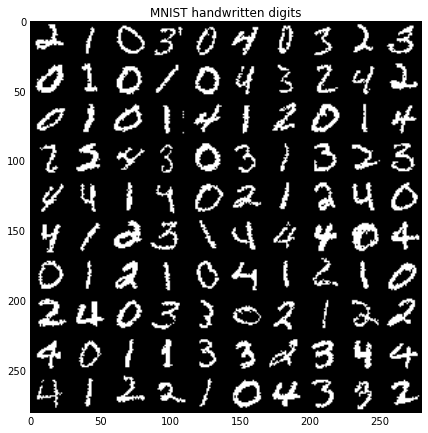

In [4]:
#plot a few MNIST examples
def plot_samples(x,title=''):
    idx = 0
    canvas = np.zeros((28*10, 10*28))
    for i in range(10):
        for j in range(10):
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
            idx += 1
    plt.figure(figsize=(7, 7))
    plt.imshow(canvas, cmap='gray')
    plt.title(title)
    plt.show()

plot_samples(x_train[:100],title='MNIST handwritten digits')

In [5]:
#defined a couple of helper functions
c = - 0.5 * math.log(2*math.pi)
def log_bernoulli(x, p, eps=0.0):
    p = T.clip(p, eps, 1.0 - eps)
    return -T.nnet.binary_crossentropy(p, x)

def kl_normal2_stdnormal(mean, log_var):
    return -0.5*(1 + log_var - mean**2 - T.exp(log_var))


In [6]:
from lasagne.layers import InputLayer,DenseLayer,get_output, get_all_params
from lasagne.nonlinearities import rectify, sigmoid
from samplelayer import SimpleSampleLayer

num_features = x_train.shape[-1]
num_latent_z = 42 ### Changed from 2 -> 42

#MODEL SPECIFICATION

#ENCODER
l_in_x = InputLayer(shape=(None, num_features))
l_enc = DenseLayer(l_in_x, num_units=128, nonlinearity=rectify)
l_enc2 = DenseLayer(l_enc, num_units=128, nonlinearity=rectify) ### Added enc layer
l_enc3 = DenseLayer(l_enc2, num_units=128, nonlinearity=rectify) ### Added enc layer
l_enc4 = DenseLayer(l_enc3, num_units=128, nonlinearity=rectify) ### Added enc layer
l_muq = DenseLayer(l_enc4, num_units=num_latent_z, nonlinearity=None)     #mu(x)
l_logvarq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=lambda x: T.clip(x,-10,10)) #logvar(x), 
l_z = SimpleSampleLayer(mean=l_muq, log_var=l_logvarq) #sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))
#we split the model into two parts to allow sampling from the decoder model separately
#DECODER
l_in_z = InputLayer(shape=(None, num_latent_z))
l_dec = DenseLayer(l_in_z, num_units=128, nonlinearity=rectify) 
l_dec2 = DenseLayer(l_dec, num_units=128, nonlinearity=rectify) ### Added dec layer
l_dec3 = DenseLayer(l_dec2, num_units=128, nonlinearity=rectify) ### Added dec layer
l_dec4 = DenseLayer(l_dec3, num_units=128, nonlinearity=rectify) ### Added dec layer
l_mux = DenseLayer(l_dec4, num_units=num_features, nonlinearity=sigmoid)  #reconstruction of input using a sigmoid output since mux \in [0,1] 

In [7]:

sym_x = T.matrix('x')
sym_z = T.matrix('z')

z_train, muq_train, logvarq_train = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=False)
mux_train = get_output(l_mux,{l_in_z:z_train},deterministic=False)

z_eval, muq_eval, logvarq_eval = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=True)
mux_eval = get_output(l_mux,{l_in_z:z_eval},deterministic=True)

mux_sample = get_output(l_mux,{l_in_z:sym_z},deterministic=True)

#define the cost function
def LogLikelihood(mux,x,muq,logvarq):
    log_px_given_z = log_bernoulli(x, mux, eps=1e-6).sum(axis=1).mean() #note that we sum the latent dimension and mean over the samples
    KL_qp = kl_normal2_stdnormal(muq, logvarq).sum(axis=1).mean() * 0 ### Removed KL term
    LL = log_px_given_z - KL_qp
    return LL, log_px_given_z, KL_qp

LL_train, logpx_train, KL_train = LogLikelihood(mux_train, sym_x, muq_train, logvarq_train)
LL_eval, logpx_eval, KL_eval = LogLikelihood(mux_eval, sym_x, muq_eval, logvarq_eval)

all_params = get_all_params([l_z,l_mux],trainable=True)

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(-LL_train, all_params)

# Set the update function for parameters. The Adam optimizer works really well with VAEs.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=1e-2)

f_train = theano.function(inputs=[sym_x],
                          outputs=[LL_train, logpx_train, KL_train],
                          updates=updates)

f_eval = theano.function(inputs=[sym_x],
                         outputs=[LL_eval, logpx_eval, KL_eval])

f_z = theano.function(inputs=[sym_x],
                         outputs=[z_eval])

f_sample = theano.function(inputs=[sym_z],
                         outputs=[mux_sample])

f_recon = theano.function(inputs=[sym_x],
                         outputs=[mux_eval])



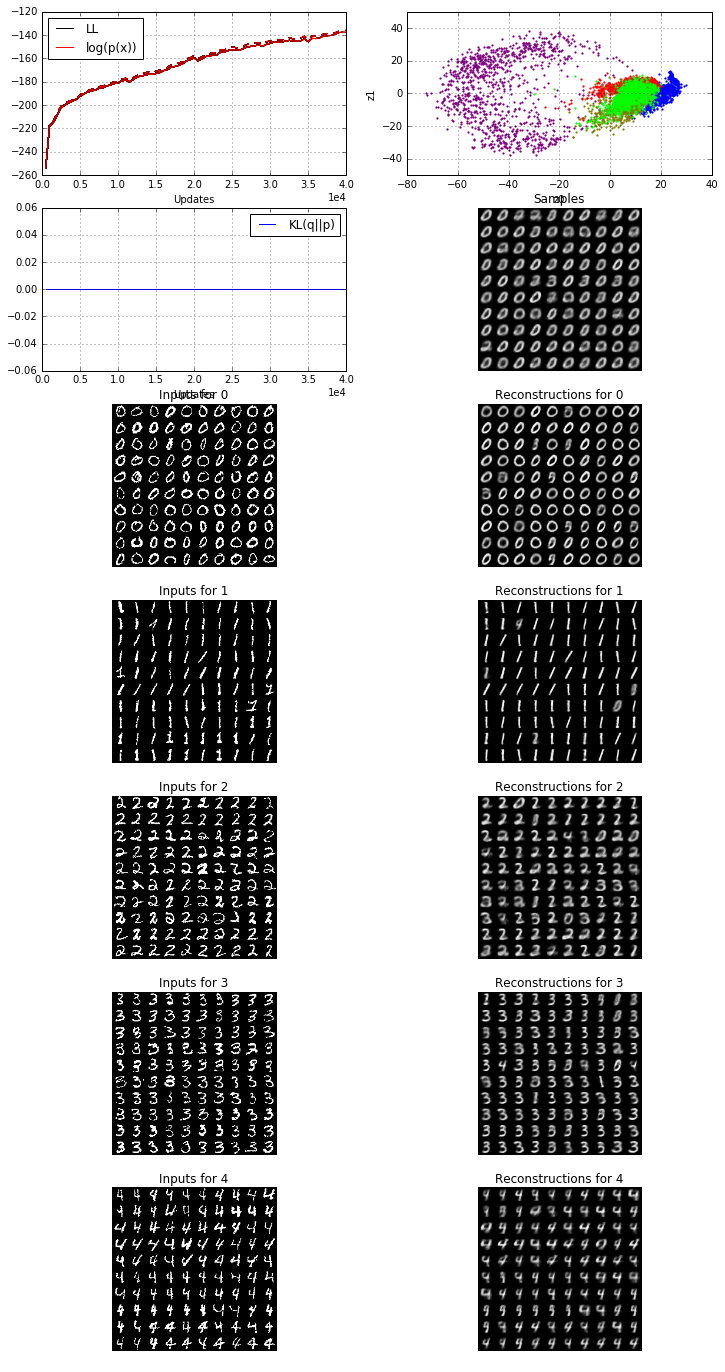

In [8]:
from sklearn.decomposition import PCA

batch_size = 100
samples_to_process = 4e4 ### Changed from 1e4 to 2e4 samples, and 2e4 -> 4e4
val_interval = 5e2
 
LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]
samples_processed = 0
plt.figure(figsize=(12, 24))
valid_samples_processed = []

try:
    while samples_processed < samples_to_process:
        _LL_train, _KL_train, _logpx_train = [],[],[]
        idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)  
        x_batch = x_train[idxs]
        out = f_train(x_batch)
        samples_processed += batch_size
           
        if samples_processed % val_interval == 0:
            valid_samples_processed += [samples_processed]
            out = f_eval(x_train)
            LL_train += [out[0]] 
            logpx_train += [out[1]]
            KL_train += [out[2]]
            
            out = f_eval(x_valid)
            LL_valid += [out[0]]
            logpx_valid += [out[1]]
            KL_valid += [out[2]]
            
            z_eval = f_z(x_valid)[0]
            x_sample = f_sample(np.random.normal(size=(100, num_latent_z)).astype('float32'))[0]
            x_recon = f_recon(x_valid)[0]
            
            plt.subplot(num_classes+2,2,1)
            plt.legend(['LL', 'log(p(x))'], loc=2)
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, LL_train, color="black")
            plt.plot(valid_samples_processed, logpx_train, color="red")
            plt.plot(valid_samples_processed, LL_valid, color="black", linestyle="--")
            plt.plot(valid_samples_processed, logpx_valid, color="red", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            ### Using PCA to represent the many number of latent units
            pca = PCA(n_components=2)
            z_eval_reduced = pca.fit_transform(z_eval)
        
            plt.subplot(num_classes+2,2,2)
            plt.cla()
            plt.xlabel('z0'), plt.ylabel('z1')
            color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
            for i in range(num_classes):
                clr = next(color)
                plt.scatter(z_eval_reduced[targets_valid==i, 0], z_eval_reduced[targets_valid==i, 1], c=clr, s=5., lw=0, marker='o', )
            plt.grid('on')
            
            plt.savefig("out52.png")
            display(Image(filename="out52.png"))
            clear_output(wait=True)
            
            plt.subplot(num_classes+2,2,3)
            plt.legend(['KL(q||p)'])
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, KL_train, color="blue")
            plt.plot(valid_samples_processed, KL_valid, color="blue", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,4)
            plt.cla()
            plt.title('Samples')
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_sample[idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            c=0
            for k in range(5, 5 + num_classes*2, 2):
                plt.subplot(num_classes+2,2,k)
                plt.cla()
                plt.title('Inputs for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((28*10, 10*28))
                for i in range(10):
                    for j in range(10):
                        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_valid[targets_valid==c][idx].reshape((28, 28))
                        idx += 1
                plt.imshow(canvas, cmap='gray')

                plt.subplot(num_classes+2,2,k+1)
                plt.cla()
                plt.title('Reconstructions for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((28*10, 10*28))
                for i in range(10):
                    for j in range(10):
                        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_recon[targets_valid==c][idx].reshape((28, 28))
                        idx += 1
                plt.imshow(canvas, cmap='gray')
                c += 1
        
except KeyboardInterrupt:
    pass


### Exercise 1 - Analyzing the VAE
1. The above implementation of a VAE is very simple.
    - *Experiment with the number of layers and non-linearities in order to improve the reconstructions.*
    - **Answer:** Tried with 4 layers for enc and dec. The Kullback-Leibler divergence was much less smooth during training, but where it settled at ~5.0 with 1 layer, this time it ended around 2.7. It does look like the network could use some more examples to train on though.
    - **Answer:** With 20k samples the KL divergence stabilizes around 3.0.
    - *Try to increase the number of digit classes in the training set and analyze the results.*
    - **Answer:** Using 5 digits, the reconstruction of the 0's and 1's do fine, but the rest are pretty bad (3 was best). KL divergence started out alright but climbed to 4.0
       
2. Complexity of the bottleneck.
    - *Increase the number of units in the latent layer and train.*
    - *Visualize by using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).*
    - **Answer:** Using 42 units in the latent layer did not do much for the digits beyond 0's and 1's. 
    - **Answer:** By using 4e4 samples the network improves dramatically for 3's and 4's, but 2's are almost all wrong in the reconstructions.
3. Analyzing the KL-term.
    - *Remove the KL-term ($KL \cdot 0$) and analyze what happens to the training.*
    - **Answer:** Training seems to be much slower than before and the reconstructions are generally more blurry, and wrong reconstructions of outlying digits (e.g. 0 that is really narrow and almost looks like a 1) are more prevalent. Reconstructions for 2's are actually better than before though.

4. Use the original paper http://arxiv.org/pdf/1312.6114v10.pdf or [this blog](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) to explain what the reparameterization trick does.

5. The VAE is a probablistic model. We could model $p(x,z,y)$ where $y$ is the label information. Explain how this model could handle semi-supervised learning? You can look through the papers https://arxiv.org/pdf/1406.5298.pdf or  https://arxiv.org/pdf/1602.05473v4.pdf. You'll have to implement this in lab53.

6. Sampling in the VAE.
    - *Explain how one could implement multiple samples in the VAE and how that would improve learning*.
    - *Look through https://arxiv.org/abs/1509.00519 and explain importance weighted auto-encoders.*
    - *Implement sampling.*